# Preprocessing (imputation, standardization, final clean) and modeling
sklearn modeling the median imputed training data using min/max clinically guided aggregation. 
preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

#memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('seaborn-white')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

## importing datasets and doing final formatting/processing

In [2]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path, lower_window, upper_window, folder, date, time_col, time_var, patient_df, categorical, save_boolean
#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 1.05 s


In [3]:
len(patients)

15412

time: 2.91 ms


In [4]:
len(icustay_id)

19633

time: 2.03 ms


In [59]:
55/7000 

0.007857142857142858

time: 32.7 ms


In [5]:
folder

'24_hr_window'

time: 1.73 ms


In [6]:
# ###########
# save_boolean=False
# ############

time: 225 µs


In [7]:
address=str(repository_path)+'/data/cleaned_merged_agg/'+'%s/'%(folder)
train_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'train')), index_col=0)
test_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'test')), index_col=0)
longneg_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'longneg')), index_col=0)

time: 186 ms


In [8]:
### added 11/8/19: removed daily sofa score from prediction model, since the components used to calculate it are already in model
### 12/12/19:  #removing o2_flow since it is mostly sparce and is not a helpful variable
train_data.drop('daily_sofa', axis=1, inplace=True)
test_data.drop('daily_sofa', axis=1, inplace=True)
longneg_data.drop('daily_sofa', axis=1, inplace=True)
train_data.drop('o2_flow', axis=1, inplace=True)
test_data.drop('o2_flow', axis=1, inplace=True)
longneg_data.drop('o2_flow', axis=1, inplace=True)
categorical.remove('o2_flow')

time: 13 ms


In [9]:
train_data['pao2fio2ratio'].head()

0    0.145556
1    0.087095
2    0.017347
3    0.145556
4    0.145556
Name: pao2fio2ratio, dtype: float64

time: 3.25 ms


## getting descriptive numbers for publication

In [7]:
final_pt_df2.head()#['icustay_id'].nunique()

,icustay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,...,subject_id,dod_hosp,dod_ssn,ab_course,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin,hadm_id
0,294638,2191-03-16 00:00:00,22,2191-03-16 00:29:31,1213116,2191-03-16,2191-03-22,0 days 00:00:00.000000000,2191-03-16,2191-03-22,...,4,NaN,NaN,full,STAPH AUREUS COAG +,BLOOD CULTURE,2191-03-16 00:00:00,positive,C_pos/A_full,185777
1,220597,2149-11-10 09:40:00,45,2149-11-09 13:07:02,2089126,2149-11-10,2149-11-15,0 days 00:00:00.000000000,2149-11-10,2149-11-15,...,9,2149-11-14,2149-11-14,full,NaN,NaN,2149-11-10 09:40:00,negative,C_neg/A_full,150750
2,232669,2104-08-11 00:00:00,60,2104-08-08 02:08:17,616189,2104-08-11,2104-08-12,0 days 00:00:00.000000000,2104-08-11,2104-08-12,...,12,2104-08-20,2104-08-20,partial,NaN,NaN,2104-08-11 00:00:00,negative,C_neg/A_partial,112213
3,273430,2108-08-05 20:42:00,69,2108-08-05 16:26:09,2572274,2108-08-06,2108-08-08,1 days 00:00:00.000000000,2108-08-06,2108-08-08,...,19,NaN,2109-08-18,partial,NaN,NaN,2108-08-05 20:42:00,negative,C_neg/A_partial,109235
4,217847,2134-09-11 09:35:00,70,2134-09-11 20:50:04,1388217,2134-09-12,2134-09-13,1 days 00:00:00.000000000,2134-09-12,2134-09-13,...,21,2135-02-08,2135-02-08,full,NaN,NaN,2134-09-11 09:35:00,negative,C_neg/A_full,109451


time: 36.2 ms


In [67]:
final_pt_df2['final_bin'].value_counts()

C_neg/A_partial    7867
C_neg/A_full       7401
C_pos/A_full       2438
C_pos/A_partial    1927
Name: final_bin, dtype: int64

time: 4.81 ms


**duration of ab across groups and in final cohort**

In [11]:
final_pt_df2.loc[final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full']),'subject_id'].nunique()

8938

time: 4.66 ms


In [19]:
final_pt_df2['abduration']=pd.to_timedelta(final_pt_df2['abduration'])
(final_pt_df2.groupby('final_bin')['abduration'].describe())

,count,mean,std,min,25%,50%,75%,max
final_bin,,,,,,,,
C_neg/A_full,7401,9 days 01:45:39.035265,7 days 15:16:42.607076,0 days,5 days,7 days,11 days,153 days
C_neg/A_partial,7867,2 days 01:52:56.255243,1 days 05:29:25.401829,0 days,1 days,2 days,3 days,4 days
C_pos/A_full,2438,9 days 10:14:51.878589,8 days 02:15:34.133356,0 days,5 days,7 days,11 days,97 days
C_pos/A_partial,1927,2 days 06:17:22.449403,1 days 05:19:51.665569,0 days,1 days,2 days,3 days,4 days


time: 26.3 ms


In [22]:
(final_pt_df2.loc[
    final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full','C_neg/A_full']),'abduration']
                     .describe())

count                     17706
mean     6 days 00:20:19.925449
std      6 days 19:35:28.220372
min             0 days 00:00:00
25%             2 days 00:00:00
50%             4 days 00:00:00
75%             8 days 00:00:00
max           153 days 00:00:00
Name: abduration, dtype: object

time: 8.6 ms


In [53]:
# unadjusted_abday1=np.array(final_pt_df2.loc[
#     final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full','C_neg/A_full']),'abduration'].dt.days)

# unadjusted_abday2=np.array(final_pt_df2.loc[
#     final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full']),'abduration'].dt.days)

# adjusted_abday1=np.array(final_pt_df2.loc[
#     final_pt_df2['final_bin'].isin(['C_pos/A_full','C_neg/A_full']),'abduration'].dt.days)

# adjusted_abday2=np.array(final_pt_df2.loc[
#     final_pt_df2['final_bin'].isin(['C_pos/A_full']),'abduration'].dt.days)




time: 8.7 ms


**getting number of patients that were coded as prolonged based on death**

In [66]:
# (pd.to_datetime(ssc_t0ab_t0ssc['t_end_consec'])+ pd.DateOffset(1)) 
#      >= pd.to_datetime(ssc_t0ab_t0ssc['dod_ssn']
#list(final_pt_df2)
print(
len(final_pt_df2[(pd.to_datetime(final_pt_df2['t_end'])+ pd.DateOffset(1))>= pd.to_datetime(final_pt_df2['dod_ssn'])]),

len(final_pt_df2[(pd.to_datetime(final_pt_df2['t_end']))>= pd.to_datetime(final_pt_df2['dod_ssn'])]),
len(final_pt_df2[(pd.to_datetime(final_pt_df2['t_end'])+ pd.DateOffset(1))>= pd.to_datetime(final_pt_df2['dod_ssn'])+ pd.DateOffset(1)])
)


# i considered any patient who had their last antibiotic date at or after either 
# #hospital or ssn DOD as "full" ab course OR having their last ab dose within 24 hours of their date of death (either dod). 

1266 934 934
time: 34.2 ms


In [61]:
final_pt_df2['t_end']

0        2191-03-22
1        2149-11-15
2        2104-08-12
3        2108-08-08
4        2134-09-13
            ...    
19628    2157-03-04
19629    2191-08-25
19630    2180-12-01
19631    2181-02-02
19632    2147-02-10
Name: t_end, Length: 19633, dtype: object

time: 7.68 ms


**demographics**

In [12]:
list(train_data)

['icustay_id',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'weight',
 'yearsold',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 "('max', 'calcium')",
 "('max', 'sodium')",
 "('max', 'wbc')",
 "('min', 'calcium')",
 "('min', 'sodium')",
 "('min', 'wbc')",
 'any_vasoactives',
 'bands',
 'cancer_elix',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'ethnicity',
 'gender',
 'leukocyte',
 'nitrite',
 'norepinephrine',
 'pco2',
 'phenylephrine',
 'rrt',
 'vasopressin',
 'vent_recieved']

time: 2.36 ms


In [13]:
full_demo=pd.concat([train_data[['icustay_id','yearsold','ethnicity','gender']],test_data[['icustay_id','yearsold','ethnicity','gender']]])

time: 4.67 ms


In [14]:
full_demo.describe()

,icustay_id,yearsold
count,10305.000000,10305.000000
mean,249857.183212,-0.018518
std,28968.046750,0.094015
min,200012.000000,-0.417086
25%,224498.000000,-0.063945
50%,249804.000000,0.002141
75%,275055.000000,0.052154
max,299995.000000,0.094968


time: 19.9 ms


In [15]:
full_demo.head()

,icustay_id,yearsold,ethnicity,gender
0,200012.0,-0.206692,asian,F
1,200014.0,0.074783,unknown/other,M
2,200033.0,0.004945,white/nonhispanic,M
3,200036.0,0.037873,white/nonhispanic,M
4,200055.0,-0.219450,black,F


time: 7.21 ms


In [16]:
full_demo.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    7867
C_pos/A_full       2438
Name: final_bin, dtype: int64

time: 18.5 ms


In [17]:
full_demo['yearsold'].min()

-0.41708575475214704

time: 2.5 ms


In [18]:
full_demo['ethnicity'].value_counts()

white/nonhispanic    7472
black                1130
unknown/other         995
hispanic              433
asian                 275
Name: ethnicity, dtype: int64

time: 4.29 ms


In [19]:
full_demo['ethnicity'].value_counts()

white/nonhispanic    7472
black                1130
unknown/other         995
hispanic              433
asian                 275
Name: ethnicity, dtype: int64

time: 4.52 ms


In [20]:
full_demo['gender'].value_counts()

M    5706
F    4599
Name: gender, dtype: int64

time: 4.53 ms


In [21]:
test_data[['icustay_id','yearsold','ethnicity','gender']].head()

,icustay_id,yearsold,ethnicity,gender
0,200030.0,-0.057816,black,M
1,200063.0,-0.171266,unknown/other,M
2,200078.0,-0.002132,white/nonhispanic,M
3,200109.0,0.025988,unknown/other,M
4,200116.0,-0.045266,white/nonhispanic,M


time: 7.98 ms


In [22]:
train_data.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 21.4 ms


In [23]:
test_data.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    2355
C_pos/A_full        745
Name: final_bin, dtype: int64

time: 17.5 ms


In [24]:
final_pt_df2['final_bin'].value_counts()

C_neg/A_partial    7867
C_neg/A_full       7401
C_pos/A_full       2438
C_pos/A_partial    1927
Name: final_bin, dtype: int64

time: 5.57 ms


## back to the formatting and final preprocessing

In [25]:
def rename_fxn(data):
    """
    renames data columns to be more readable.
    """
    rename_dic={
    "('max', 'sodium')": "maxSodium" ,
    "('max', 'sodium')" : "maxSodium",
    "('min', 'sodium')" : "minSodium",
    "('max', 'calcium')" : "maxCalcium",
    "('min', 'calcium')" : "minCalcium",
    "('max', 'sodium')": "maxSodium",
    "('min', 'sodium')": "minSodium",
    "('max', 'wbc')": "maxWBC",
    "('min', 'wbc')": "minWBC"#,
#     "bands": "ibands",
#     "pco2": "ipco2"
        }
    data=data.rename(rename_dic, axis='columns').copy()
    return(data)

time: 1.09 ms


In [26]:
def last_minute_clean(data):
    "some last minute data cleaning steps that were missed prior to this. eventually should be transitioned to earlier in pipeline"
    data.loc[data['ethnicity'].isnull(), 'ethnicity']='unknown/other'
    data.loc[data['yearsold']>90,"yearsold"]=90
    return(data)

time: 1.02 ms


In [27]:
# def standardize_fxn(data):
#     """
#     function operations:
#     2) standardize last 2 columns to be standardized (weight and age)
#     """
#     from sklearn.impute import SimpleImputer
    
#     ### I chose to standardize the weight and age here (after the feature_aggregation)... I can't remember why though. either way, it doesn't affect anything, but is a bit clunky. 
#     weight_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).median()
#     weight_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
#     weight_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
#     weight_iqr=weight_quant3-weight_quant1
#     #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

#     age_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).median()
#     age_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.25)
#     age_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.75)
#     age_iqr=age_quant3-age_quant1

#     #converting to log scaled standardized data for age/weight
#     data['weight']=data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
#     data['yearsold']=data['yearsold'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
#     return(data)

time: 426 µs


In [28]:
def remap_categorical(data, categorical):
    """remapps the 0 and 1 back to interpretable values in the dataframe. useful to use before onehot encoding. also useful to fill in some missing values and nan's"""   

    remapping_dic={
    'vent_recieved':{0:'None', 2:'Mech' , 1:'OxygenTherapy', np.nan:'None'},
    'cancer_elix':{0:'no_cancer_cormorb', 1:'cancer_comorbidity'},
    'gender':{0:'F', 1:'M', np.nan:'NA'},
    'leukocyte':{0:'Neg/Not_tested' , 1:'pos'},
    'nitrite':{0:'Neg/Not_tested' , 1:'pos'},
    'rrt':{0:'not_recieved' , 1:'recieved'},
    'phenylephrine':{0:'not_recieved' , 1:'recieved'},
    'norepinephrine':{0:'not_recieved' , 1:'recieved'},
    'vasopressin':{0:'not_recieved' , 1:'recieved'},
    'dobutamine':{0:'not_recieved' , 1:'recieved'},
    'dopamine':{0:'not_recieved' , 1:'recieved'},
    'epinephrine':{0:'not_recieved' , 1:'recieved'},
    'any_vasoactives':{0:'not_recieved' , 1:'recieved'},
    'o2_flow':{0:'no_flow', 1:"recieved_O2"}
    }
    
    for col in list(data):
        if col in ['ethnicity', 'bands','pco2']:
            pass
        elif col in categorical:
            data[col]=data[col].replace(remapping_dic[col])
        
    return(data)

time: 2.15 ms


In [29]:
def onehotencoder(data, categorical):
    """
    function operations:
    3) convert categorical columns to proper format
    """

    data = pd.get_dummies(data, columns = categorical, drop_first=True)
    return(data)

time: 715 µs


In [30]:
def median_imputer(data, categorical):
    """
    function operations:
    4) median impute
    """
    from sklearn.impute import SimpleImputer
    
    #pop outcome off
    outcome= data.pop("final_bin").values
    notcat= [x for x in list(data) if x not in categorical]

    #impute
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    data_imp = imp.fit_transform(data[notcat])   
    
    df= pd.DataFrame(data_imp, columns=list(data[notcat]))
    df.set_index(data.index, inplace=True)
    df[categorical]= data[categorical].copy()
    
    #reattach outcome
    df['final_bin']= outcome
    return(df)

time: 1.54 ms


In [31]:
def preprocessing(data, encode=True, twoclass=True):
    """
    function operations: (each one of the below steps uses one of the functions defined above.)
    1) rename columns
    2) some last minute cleanup
    3) standardize last 2 columns to be standardized
    4) median impute 
    5) remap categorical values to be interpretable and encode them for modeling
    6)
    """
    from sklearn.impute import SimpleImputer
    global categorical
    
    ###rename
    data=rename_fxn(data)
    
    ###some last minute data cleaning steps that were missed prior to this. eventually should be transitioned to earlier in pipeline
    data=last_minute_clean(data)
    
    ##scale & standardize the remaining 2 columns (age and weight)
    #data=standardize_fxn(data)
    
    ### onehot encoding categorical var
    
    #remapping the 0 and 1 back to categorical values for more interpreable onehotencoding column headings
    data=remap_categorical(data, categorical)
    
    #impute
    data= median_imputer(data, categorical)
    
    #onehotencoding
    if encode==True:
        data=onehotencoder(data, categorical)
    
    #binarizing and poping outcome for training data; handling outcome for holdout long/neg
    if twoclass==True:
        data.loc[data['final_bin']=="C_pos/A_full","final_bin"]=1
        data.loc[data['final_bin']=="C_neg/A_partial","final_bin"]=0
        data['final_bin']=pd.to_numeric(data['final_bin'])
    
    else:
        data.loc[data['final_bin']=="C_neg/A_full","final_bin"]=0
        data['final_bin']=pd.to_numeric(data['final_bin'])

        
    ## establishing training data and labels
    x= data.copy()
    z_icustay_id=x.pop('icustay_id')
    y= x.pop("final_bin").values
    
    return(x, y, z_icustay_id)

time: 2.09 ms


# todo: get some statistics on missingness right before i perform imputation.

In [32]:
x_train, y_train, z_icustay_id = preprocessing(pd.merge(train_data, final_pt_df2[['icustay_id','final_bin']]))
x_test, y_test, z_icustay_id_test= preprocessing(pd.merge(test_data, final_pt_df2[['icustay_id','final_bin']]))
x_longneg, y_longneg, z_icustay_id_longneg= preprocessing(pd.merge(longneg_data, final_pt_df2[['icustay_id','final_bin']]), twoclass=False)
z_subject_id=pd.merge(pd.DataFrame(z_icustay_id), final_pt_df2[['icustay_id','subject_id']], how='left')['subject_id'] #7205

time: 467 ms


In [36]:
x_train2, y_train2, z_icustay_id2 = preprocessing(pd.merge(train_data, final_pt_df2[['icustay_id','final_bin']]),encode=False)
x_test2, y_test2, z_icustay_id_test2= preprocessing(pd.merge(test_data, final_pt_df2[['icustay_id','final_bin']]),encode=False)


time: 236 ms


In [32]:
###checking distribution of all categorical variables
full_set=pd.concat([x_train2,x_test2])
for element in categorical:
    print("###{}###".format(element))
    print(full_set[element].value_counts(), '\n')

###ethnicity###
white/nonhispanic    7472
black                1130
unknown/other         995
hispanic              433
asian                 275
Name: ethnicity, dtype: int64 

###bands###
absent    8952
<10        856
>10        497
Name: bands, dtype: int64 

###pco2###
absent    6798
<50       2499
>50       1008
Name: pco2, dtype: int64 

###any_vasoactives###
not_recieved    7362
recieved        2943
Name: any_vasoactives, dtype: int64 

###leukocyte###
Neg/Not_tested    8959
pos               1346
Name: leukocyte, dtype: int64 

###nitrite###
Neg/Not_tested    10055
pos                 250
Name: nitrite, dtype: int64 

###vent_recieved###
Oxygen    4912
Mech      4664
None       729
Name: vent_recieved, dtype: int64 

###dobutamine###
not_recieved    10205
recieved          100
Name: dobutamine, dtype: int64 

###gender###
M    5706
F    4599
Name: gender, dtype: int64 

###dopamine###
not_recieved    9830
recieved         475
Name: dopamine, dtype: int64 

###epinephrine###
not

In [38]:
len(full_set)

10305

time: 1.79 ms


#### quick qc to ensure the imputation and standardization of age/weight worked

In [39]:
train_data[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,NaN,-0.121245,-0.206692
1,0.037089,-0.064565,0.074783
2,-0.004314,-0.012014,0.004945
3,NaN,0.007438,0.037873
4,-0.035714,-0.094731,-0.219450


time: 6.73 ms


In [34]:
train_data[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,NaN,51.2,32.988959
1,0.037089,62.0,84.728186
2,0.008507,74.0,67.145099
3,0.020977,79.0,74.934136
4,-0.021991,56.0,31.593200


time: 12.4 ms


In [40]:
x_train[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,0.004273,-0.121245,-0.206692
1,0.037089,-0.064565,0.074783
2,-0.004314,-0.012014,0.004945
3,0.004273,0.007438,0.037873
4,-0.035714,-0.094731,-0.219450


time: 7.2 ms


In [35]:
x_train[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,0.008507,-1.184856,-1.725281
1,0.037089,-0.630958,0.624219
2,0.008507,-0.117409,0.041273
3,0.020977,0.072685,0.316127
4,-0.021991,-0.925748,-1.831772


time: 9.39 ms


In [36]:
len(list(x_train))

53

time: 2.69 ms


### getting table for paper

In [41]:
list(x_train)

['bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'weight',
 'yearsold',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'ethnicity_black',
 'ethnicity_hispanic',
 'ethnicity_unknown/other',
 'ethnicity_white/nonhispanic',
 'bands_>10',
 'bands_absent',
 'pco2_>50',
 'pco2_absent',
 'any_vasoactives_recieved',
 'leukocyte_pos',
 'nitrite_pos',
 'vent_recieved_None',
 'vent_recieved_Oxygen',
 'dobutamine_recieved',
 'gender_M',
 'dopamine_recieved',
 'epinephrine_recieved',
 'norepinephrine_recieved',
 'phenylephrine_recieved',
 'rrt_recieved',
 'vasopressin_recieved',
 'cancer_elix_no_cancer_cormorb']

time: 2.06 ms


In [42]:
pd.merge(train_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 16 ms


In [43]:
pd.merge(test_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    2355
C_pos/A_full        745
Name: final_bin, dtype: int64

time: 14.3 ms


## looking at correlation of all variables

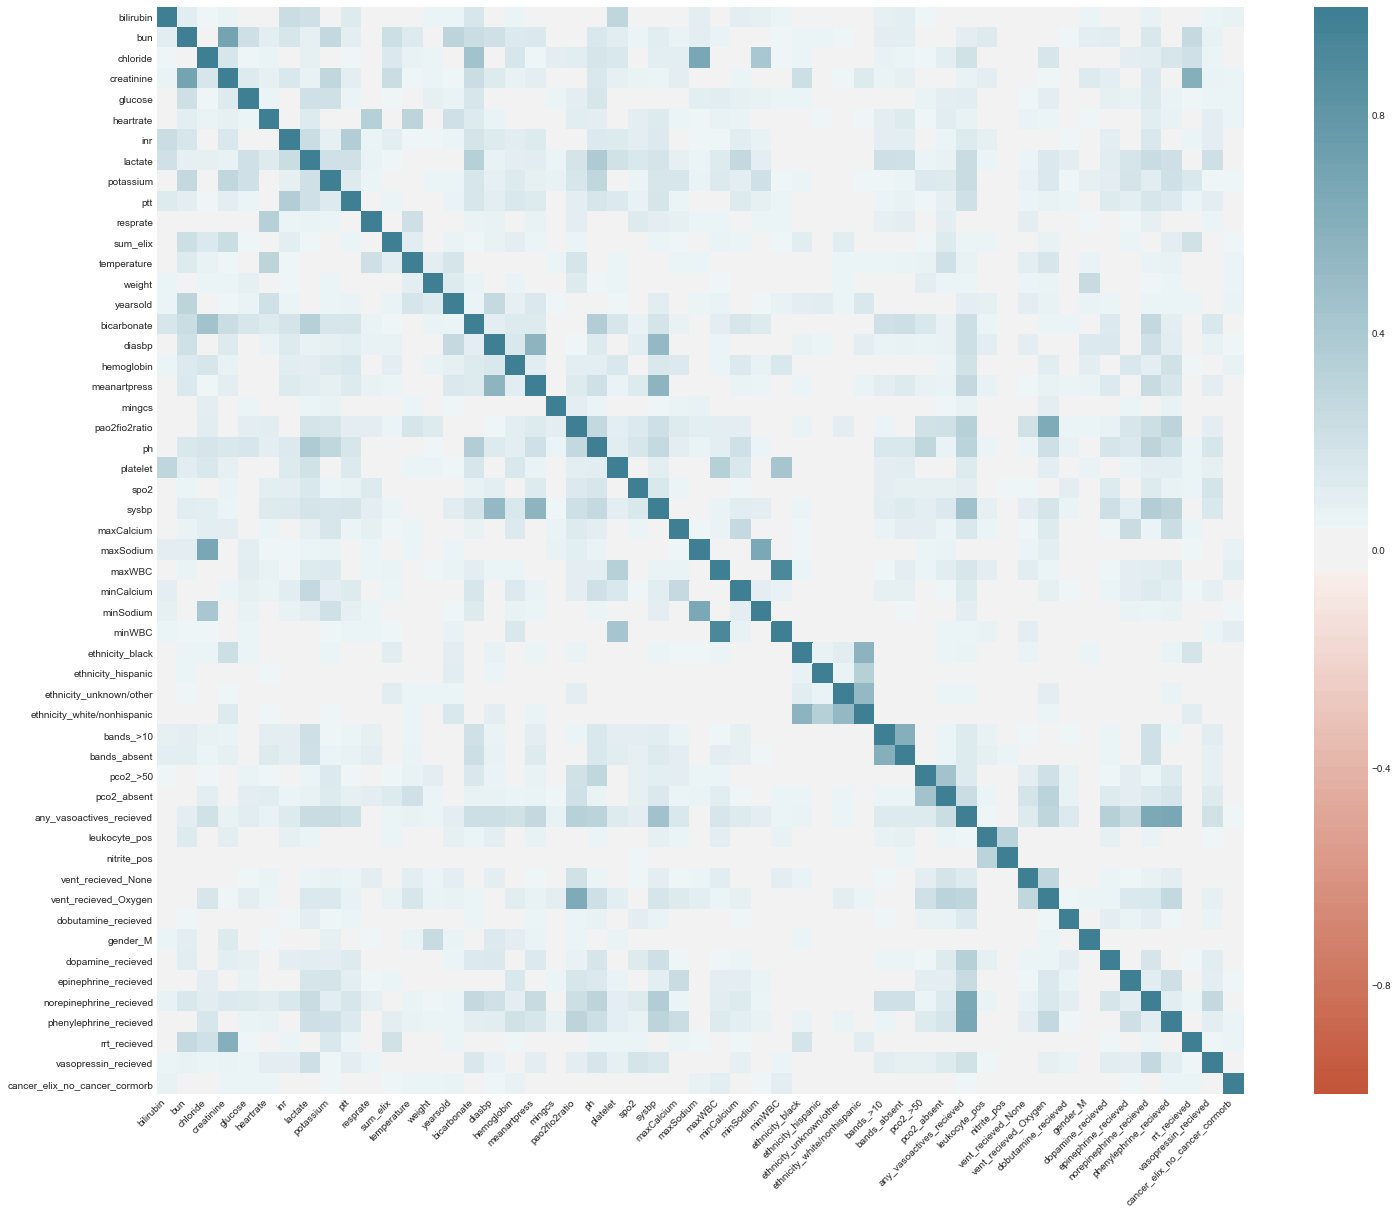

time: 1.79 s


In [44]:
corr = x_train.corr().abs()

plt.figure(figsize=(25, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [45]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
cor_df=pd.DataFrame(sol)#.sort_values(kind="quicksort") #[-10:0])
cor_df=cor_df.reset_index()
cor_df=cor_df.rename(columns={'level_0': 'corx', 'level_1': 'cory', 0:'corr'})
cor_df2=cor_df[(cor_df['corx']!=cor_df['cory']) & (cor_df['corr']>0.7)].sort_values('corr', ascending=False)
cor_df2.head()

,corx,cory,corr
0,maxWBC,minWBC,0.91524


time: 15.7 ms


### DROPING one of the 2 columns with correlation >0.7  (depreciated)

In [42]:
# x_train.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
# x_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 547 µs


### formatting x and y for modleing

In [46]:
x=np.array(x_train.copy())
y=y_train.copy() #copy of y_train
y=y.astype('int')
#time_interval=4

time: 4.07 ms


In [47]:
print(len(x_train),len(x_test))

7205 3100
time: 525 µs


In [48]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

time: 1.91 ms


In [49]:
len(list(x_train))

53

time: 1.9 ms


In [53]:
def save_df(df, df_name='default', rel_path='/data/final/'):
    """
    simple function for saving result table. uses the date and supplied df name and saves to the savepath specified above.
    """
    global folder
    
    save_path= str(repository_path)+rel_path
    
    address=save_path+'{}_{}/'.format(date,folder)
    if not os.path.exists(address):
        print(address)
        os.makedirs(address)
    else:
        print(address)
        
    if address.endswith('/')==False:
        address= address+'/'
        
    if df_name == 'default':
        df_name =[x for x in globals() if globals()[x] is df][0]
        
    pd.DataFrame(df).to_csv(Path(address+'{}_{}.csv'.format(date, df_name)))


time: 1.66 ms


In [54]:
if save_boolean==True:
    save_df(x_train, 'x_train_final', rel_path='/data/final/')
    save_df(x_test, 'x_test_final', rel_path='/data/final/')
    save_df(y_train, 'y_train_final', rel_path='/data/final/')
    save_df(y_test, 'y_test_final', rel_path='/data/final/')
    
    save_df(x_longneg, 'x_longneg_final', rel_path='/data/final/')
    save_df(y_longneg, 'y_longneg_final', rel_path='/data/final/')
    
    save_df(z_icustay_id, 'icustay_train', rel_path='/data/final/') #just added, need to rerun all models. 12-19-19
    save_df(z_icustay_id_test, 'icustay_test', rel_path='/data/final/')
    save_df(z_icustay_id_longneg, 'icustay_longneg', rel_path='/data/final/')


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window/
time: 1.1 s
